In [1]:
# Use a conda env with bitbirch installed
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
from collections import Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import os

# Define root directory
# root = os.path.dirname(os.path.abspath(__file__))
root = "."
sys.path.append(os.path.join(root, "..", "src"))
from default import CONFIGPATH

# Loading ChEMBL preprocessed data
print("Loading ChEMBL preprocessed data...")
ChEMBL = pd.read_csv(os.path.join(root, "..", "config", "chembl_processed", "activities_preprocessed.csv"), low_memory=False)

Loading ChEMBL preprocessed data...


In [2]:
print(f"Number of activities: {len(ChEMBL)}")
print(f"Number of activities with non nan values: {len(ChEMBL[ChEMBL['value'].isna() == False])}")
print(f"Number of unique compounds: {len(set(ChEMBL['compound_chembl_id']))}")
print(f"Number of unique assays: {len(set(ChEMBL['assay_chembl_id']))}")
print(f'Assay types: {Counter(ChEMBL[["assay_chembl_id", "assay_type"]].drop_duplicates(subset="assay_chembl_id")["assay_type"])}')
print(f"Number of unique targets: {len(set(ChEMBL['target_chembl_id']))}")
print(f'Target types: {Counter(ChEMBL[["target_chembl_id", "target_type"]].drop_duplicates(subset="target_chembl_id")["target_type"])}')
print(f"Relations: {Counter(ChEMBL['relation'])}")

Number of activities: 24267312
Number of activities with non nan values: 20911360
Number of unique compounds: 2756400
Number of unique assays: 1890531
Assay types: Counter({'F': 884810, 'B': 595810, 'A': 311427, 'T': 68178, 'P': 26618, 'U': 3688})
Number of unique targets: 17316
Target types: Counter({'SINGLE PROTEIN': 10731, 'ORGANISM': 2383, 'CELL-LINE': 1994, 'PROTEIN COMPLEX': 599, 'PROTEIN-PROTEIN INTERACTION': 595, 'PROTEIN FAMILY': 393, 'TISSUE': 294, 'SELECTIVITY GROUP': 123, 'NUCLEIC-ACID': 56, 'PROTEIN COMPLEX GROUP': 55, 'CHIMERIC PROTEIN': 34, 'UNKNOWN': 16, 'SUBCELLULAR': 12, 'MACROMOLECULE': 7, 'PROTEIN NUCLEIC-ACID COMPLEX': 6, '3D CELL CULTURE': 6, 'SMALL MOLECULE': 4, 'PHENOTYPE': 2, 'NON-MOLECULAR': 1, 'ADMET': 1, 'UNCHECKED': 1, 'NO TARGET': 1, 'LIPID': 1, 'OLIGOSACCHARIDE': 1})
Relations: Counter({'=': 22283277, '>': 1609239, '<': 374796})


In [3]:
LABEL = 'activity_type'
print(f"Number of standard activity types: {len(set(ChEMBL[LABEL]))}")
s = ChEMBL[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 types coverage: {out['cumulative_prop'].tolist()[100]}")

Number of standard activity types: 6068
100 types coverage: 0.95


In [4]:
LABEL = 'unit'
print(f"Number of units: {len(set(ChEMBL[LABEL]))}")
s = ChEMBL[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 units coverage: {out['cumulative_prop'].tolist()[100]}")

Number of units: 2520
100 units coverage: 0.997


In [5]:
LABEL = ['activity_type', 'unit']
s = pd.DataFrame([str(i) + " -- " + str(j) for i,j in zip(ChEMBL[LABEL[0]], ChEMBL[LABEL[1]])])
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"Number of act-unit pairs: {len(out)}")
print(f"100 pairs coverage: {out['cumulative_prop'].tolist()[100]}")

Number of act-unit pairs: 12776
100 pairs coverage: 0.934


In [6]:
### FILTERING FOR PATHOGENS ###

def get_pathogen_code(pathogen):
    return str(pathogen.split()[0][0] + pathogen.split()[1]).lower() if len(pathogen.split()) > 1 else pathogen.lower()

In [7]:
# List of pathogens
pathogens = ["Acinetobacter baumannii", "Candida albicans", "Campylobacter", "Escherichia coli", "Enterococcus faecium", "Enterobacter",
             "Helicobacter pylori", "Klebsiella pneumoniae", "Mycobacterium tuberculosis", "Neisseria gonorrhoeae", "Pseudomonas aeruginosa",
             "Plasmodium falciparum", "Staphylococcus aureus", "Schistosoma mansoni", "Streptococcus pneumoniae"]

RESULTS = {}
# For each pathogen
pathogens = np.array(pathogens)
for pathogen in pathogens:

    print(f"Filtering for pathogen: {pathogen}...")
    pathogen_code = get_pathogen_code(pathogen)
    pathogen_data = ChEMBL[ChEMBL['target_organism'].str.contains(pathogen, case=False, na=False) | 
                    ChEMBL['assay_organism'].str.contains(pathogen, case=False, na=False)].reset_index(drop=True)

    print(f"Number of activities: {len(pathogen_data)}")
    print(f"Number of unique compounds: {len(set(pathogen_data['compound_chembl_id']))}")
    RESULTS[pathogen_code] = [len(pathogen_data), len(set(pathogen_data['compound_chembl_id']))]
    print("\n")

Filtering for pathogen: Acinetobacter baumannii...
Number of activities: 46578
Number of unique compounds: 32899


Filtering for pathogen: Candida albicans...
Number of activities: 92635
Number of unique compounds: 44546


Filtering for pathogen: Campylobacter...
Number of activities: 2202
Number of unique compounds: 692


Filtering for pathogen: Escherichia coli...
Number of activities: 284663
Number of unique compounds: 155455


Filtering for pathogen: Enterococcus faecium...
Number of activities: 15781
Number of unique compounds: 8149


Filtering for pathogen: Enterobacter...
Number of activities: 12493
Number of unique compounds: 5997


Filtering for pathogen: Helicobacter pylori...
Number of activities: 5165
Number of unique compounds: 1809


Filtering for pathogen: Klebsiella pneumoniae...
Number of activities: 51031
Number of unique compounds: 26882


Filtering for pathogen: Mycobacterium tuberculosis...
Number of activities: 714811
Number of unique compounds: 132379


Filtering

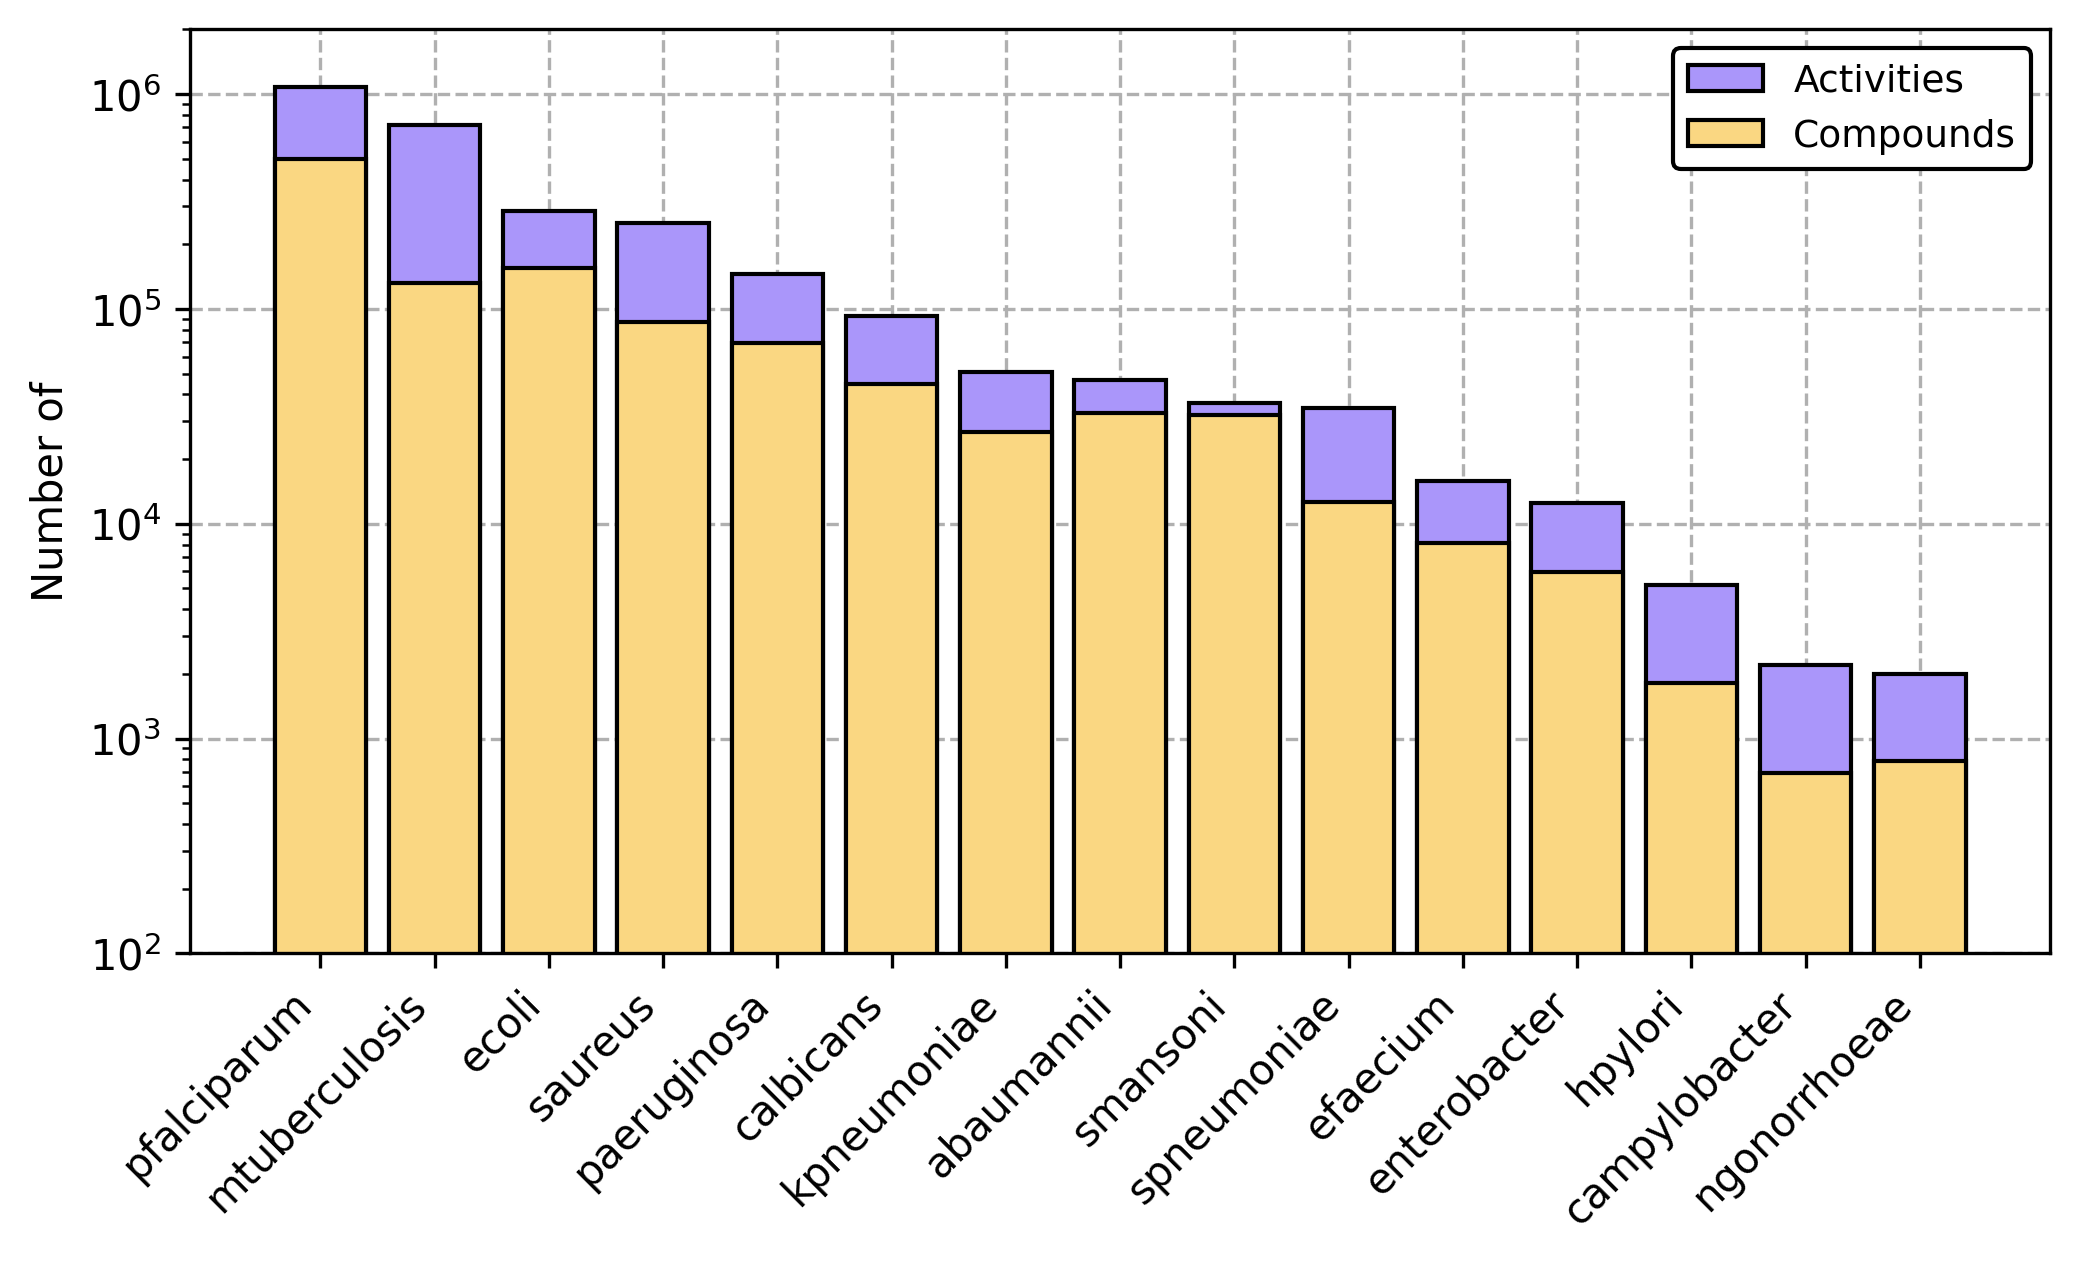

In [8]:
plt.figure(figsize=(8, 4))

x = [i for i in range(len(pathogens))]
inds = np.argsort([RESULTS[get_pathogen_code(i)][0] for i in pathogens])[::-1]
plt.bar(x, [RESULTS[get_pathogen_code(i)][0] for i in pathogens[inds]], zorder=2, ec='k', color="#AA96FA", label='Activities')
plt.bar(x, [RESULTS[get_pathogen_code(i)][1] for i in pathogens[inds]], zorder=2, ec='k', color="#FAD782", label='Compounds')

plt.ylim([10 ** 2, 2*10 ** 6])
plt.yscale('log')
plt.ylabel("Number of")
plt.xticks(x, [get_pathogen_code(i) for i in pathogens[inds]], rotation=45, ha='right')
plt.grid(linestyle='--')
plt.legend(loc='upper right', framealpha=1, edgecolor='k', prop={'size': 9})
plt.show()

In [12]:
# Filtering data for pathogens
pathogen_data = ChEMBL[ChEMBL['target_organism'].str.lower().isin([p.lower() for p in pathogens]) | 
                       ChEMBL['assay_organism'].str.lower().isin([p.lower() for p in pathogens])].reset_index(drop=True)

In [13]:
print(f"Number of activities: {len(pathogen_data)}")
print(f"Number of activities with non nan values: {len(pathogen_data[pathogen_data['value'].isna() == False])}")
print(f"Number of unique compounds: {len(set(pathogen_data['compound_chembl_id']))}")
print(f"Number of unique assays: {len(set(pathogen_data['assay_chembl_id']))}")
print(f'Assay types: {Counter(pathogen_data[["assay_chembl_id", "assay_type"]].drop_duplicates(subset="assay_chembl_id")["assay_type"])}')
print(f"Number of unique targets: {len(set(pathogen_data['target_chembl_id']))}")
print(f'Target types: {Counter(pathogen_data[["target_chembl_id", "target_type"]].drop_duplicates(subset="target_chembl_id")["target_type"])}')
print(f"Relations: {Counter(pathogen_data['relation'])}")

Number of activities: 2734239
Number of activities with non nan values: 2613952
Number of unique compounds: 710803
Number of unique assays: 129531
Assay types: Counter({'F': 112050, 'B': 16034, 'A': 1277, 'T': 151, 'U': 14, 'P': 5})
Number of unique targets: 798
Target types: Counter({'SINGLE PROTEIN': 724, 'ORGANISM': 23, 'PROTEIN COMPLEX': 17, 'PROTEIN FAMILY': 8, 'NUCLEIC-ACID': 5, 'MACROMOLECULE': 4, 'SUBCELLULAR': 4, 'SMALL MOLECULE': 2, 'PROTEIN COMPLEX GROUP': 2, 'CELL-LINE': 2, 'UNCHECKED': 1, 'NON-MOLECULAR': 1, 'ADMET': 1, 'NO TARGET': 1, 'PROTEIN NUCLEIC-ACID COMPLEX': 1, 'UNKNOWN': 1, 'LIPID': 1})
Relations: Counter({'=': 2557575, '>': 156054, '<': 20610})


In [22]:
LABEL = 'activity_type'
print(f"Number of standard activity types: {len(set(pathogen_data[LABEL]))}")
s = pathogen_data[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 types coverage: {out['cumulative_prop'].tolist()[100]}")

Number of standard activity types: 480
100 types coverage: 0.996


In [18]:
LABEL = 'unit'
print(f"Number of units: {len(set(pathogen_data[LABEL]))}")
s = pathogen_data[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 units coverage: {out['cumulative_prop'].tolist()[100]}")

Number of units: 238
100 units coverage: 1.0


In [24]:
LABEL = ['activity_type', 'unit']
s = pd.DataFrame([str(i) + " -- " + str(j) for i,j in zip(pathogen_data[LABEL[0]], pathogen_data[LABEL[1]])])
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"Number of act-unit pairs: {len(out)}")
print(f"100 pairs coverage: {out['cumulative_prop'].tolist()[100]}")

Number of act-unit pairs: 963
100 pairs coverage: 0.991


In [26]:
out[:10]

,0,count,cumulative_prop
0,PERCENTEFFECT -- %,754701,0.276
1,INHIBITION -- %,467522,0.447
2,MIC -- umol.L-1,459659,0.615
3,POTENCY -- umol.L-1,393153,0.759
4,ZSCORE -- nan,147592,0.813
5,IC50 -- umol.L-1,123603,0.858
6,ACTIVITY -- nan,55766,0.878
7,IZ -- mm,45821,0.895
8,EC50 -- umol.L-1,31314,0.907
9,ACTIVITY -- %,18099,0.913
